# FDN reverb algorithm

This notebook contains one of the algorithms I researched for my degree project, the feedback delay network. Through each cell, various comments will serve as guidance to help you understand what's being done. It is recommended to read about the FDN algorithm in order to deeply understand the code. 

The code is entirely based on the MATLAB version of it that I did, found at https://github.com/AmadoMiguel/Bachelors-degree-project/blob/master/FDN_code/FDN_v.m.

In [1]:
# First, required modules are imported
from __future__ import division
import numpy as np
import scipy.linalg as la
import random
import matplotlib.pyplot as plt
import thinkdsp
from IPython.display import Audio

# Required functions 

In [2]:
# Function that returns an array of prime numbers between two numbers (taken from: 
# https://stackoverflow.com/questions/31045518/finding-prime-numbers-using-list-comprehention)
def primNums(num1,num2):
    Primes = list(set(range(num1,num2)) - {x for x in range(num2) for y in range(2,x) if x%y == 0})            
    return Primes            

# Length-4 FDN-based reverb algorithm. An interesting fact about this version of the FDN algorithm, 
# is that each time it is executed, a different IR is calculated (delay times are randomly calculated),
# as well as damping coefficients
def FDN(inp):
    # Dry signal damping coefficient
    d = 1
    # Feedback coefficients matrix
    A = la.hadamard(4) / np.sqrt(4)
    # Post-matrix feedback damping coefficients
    g = np.power( np.random.rand(4), 1/4 )
    # Feedback signals sample-based delays (random set of 4 (high) prime numbers)
    smPrimes = primNums(2,16)
    prms1 = primNums( 2, 2 ** random.randint(smPrimes[4],smPrimes[-1]) )
    prms2 = primNums( 2, 2 ** random.randint(smPrimes[0],smPrimes[3]) )
    prm = np.array(prms1[len(prms2): ])
    indxs = np.random.permutation(len(prm))[:4]
    # Sample-based delays array
    D = prm[indxs]
    # Feedback vectors initialization
    j = max(D)
    del_lns = np.matrix( [ np.zeros(max(D)+1),np.zeros(max(D)+1),np.zeros(max(D)+1),np.zeros(max(D)+1) ] )
    # Random input-wise and output-wise damping coefficients
    b = np.power( np.random.rand(4), (1/3) )
    c = np.power( np.random.rand(4), (1/7) )
    # Main processing loop
    out = np.zeros(len(inp)) # Out initialization
    for k in range(j,len(inp)):
        # Feedback signals (delay lines) indexed at corresponding delay time
        fb_sgnls = np.array( [ del_lns[0,D[0]],del_lns[1,D[1]],del_lns[2,D[2]],del_lns[3,D[3]] ] )
        # Sample by sample output obtention
        out[k-j] = d*inp[k-j] + sum( c * fb_sgnls )
        # Feedback signals circular matrix
        del_lns[:,0] = np.transpose( np.matrix( b * np.array( [ inp[k-j],inp[k-j],inp[k-j],inp[k-j] ] ) ) + \
                       np.diag( A * np.transpose(fb_sgnls)* np.transpose(g) ) )
        del_lns[:,1:-1] = del_lns[:,0:-2]
    # Normalize output 
    out = out / np.abs(out.max())     
    return out

# Processing an audio signal

The way the FDN algorithm is used, is by calculating an IR with the FDN() function, and then using convolution.

In [23]:
# First, get the IR by passing an impulse as input to the FDN() function
imp = np.zeros(50000)              
imp[0] = 1  
# Process the impulse
IR = FDN(imp)

# Now, actual processing is performed

# Read an audio signal (You can load any .wav file)
audio = thinkdsp.read_wave(filename='ElecGtr.wav')
# Audio signal length
L = len(audio.ys)
# IR length
N = len(IR)
M = L + N - 1
# (Fast) Convolution process (frequency domain). Extract the real part
wetSig = np.fft.ifft( (np.fft.fft(audio.ys,M)*np.fft.fft(IR,M)) ).real
# Transform into a wave object
wS = thinkdsp.Wave(ys=wetSig,framerate=audio.framerate)
# Optimize processed signal
wS.make_audio()
wS.normalize()
wS.apodize()

# Visualize IR

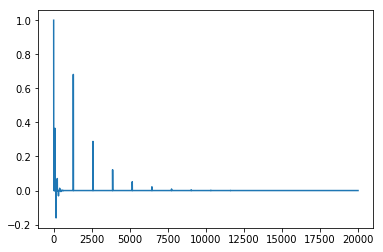

In [24]:
plt.plot(IR[:20000]) # "Only" 20000 samples

# Listen the reverb!

In [5]:
# But before, listen the original signal
Audio(audio.ys,rate=audio.framerate)

In [17]:
# Now, listen to the processed signal
Audio(wS.ys,rate=audio.framerate)